<a href="https://colab.research.google.com/github/Kimi-Gingercat/IAT360-FinalProj-SpamDetection/blob/main/SMS_Spam_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Python Libraries (pip)

In [1]:
# install some Python packages with pip

%pip install numpy torch datasets transformers evaluate --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
# let's check the version we are using

%pip freeze | grep -E '^numpy|^torch|^datasets|^transformers|^evaluate'

datasets==3.1.0
evaluate==0.4.3
numpy==1.26.4
torch @ https://download.pytorch.org/whl/cu121_full/torch-2.5.1%2Bcu121-cp310-cp310-linux_x86_64.whl
torchaudio @ https://download.pytorch.org/whl/cu121/torchaudio-2.5.1%2Bcu121-cp310-cp310-linux_x86_64.whl
torchsummary==1.5.1
torchvision @ https://download.pytorch.org/whl/cu121/torchvision-0.20.1%2Bcu121-cp310-cp310-linux_x86_64.whl
transformers==4.46.3


# Create Dataset for Fine-tuning BERT

## Load the SMS Spam Dataset

In [3]:
from datasets import load_dataset
import pandas as pd
# source: https://huggingface.co/datasets/Deysi/spam-detection-dataset
raw_dataset = load_dataset('Deysi/spam-detection-dataset')
raw_dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/581 [00:00<?, ?B/s]

(…)-00000-of-00001-daf190ce720b3dbb.parquet:   0%|          | 0.00/1.92M [00:00<?, ?B/s]

(…)-00000-of-00001-fa9b3e8ade89a333.parquet:   0%|          | 0.00/663k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8175 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2725 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8175
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2725
    })
})

In [6]:
test_df = raw_dataset['test'].to_pandas()

# Display the first 5 entries in the training set
print(test_df.head())

                                                text     label
0   Deezer.com 10,406,168 Artist DB\n\nWe have sc...  not_spam
1  🚨 ATTENTION ALL USERS! 🚨\n\n🆘 Are you looking ...      spam
2  I'm working on a stats project to test some of...  not_spam
3  [[Sorry, I cannot generate inappropriate or sp...      spam
4  L@@k at these Unbelievable diet pills that can...      spam


In [14]:
from datasets import Dataset, DatasetDict
# Add new 40 entries to training set
new_entries = [
    {"text": "Congratulations! You've won a $1000 Walmart gift card. Click now to claim your prize!", "label": "spam"},
    {"text": "Hey, just checking in to see if you're coming to the meeting later today.", "label": "not_spam"},
]

# Add new entries one by one
merged_train_dataset = raw_dataset["train"]
for entry in new_entries:
    merged_dataset = merged_dataset.add_item(entry)

# Add new 20 entries to test set
new_entries = [

]

# Add new entries one by one
merged_test_dataset = raw_dataset["test"]
for entry in new_entries:
    merged_dataset = merged_dataset.add_item(entry)

dataset = DatasetDict({
    'train': merged_train_dataset,
    'test': merged_test_dataset  # Assuming no changes to the test split
})
# Check the last few entries to confirm
dataset


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8177
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2725
    })
})

The raw dataset splits its data 25/75. It has 10900 data entries in total

## Let's create the train, validation, test sets

Split dataset into train 70%, validation 15%, test 15%

In [23]:
from datasets import DatasetDict

# Split the training set into train and validation sets (e.g., 80% train, 20% val)
split_dataset = dataset['train'].train_test_split(test_size=0.2, seed=42)
dataset = DatasetDict({
    'train': split_dataset['train'],
    'val': split_dataset['test'],  # Now used as validation set
    'test': dataset['test']   # Original test set
})
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 6541
    })
    val: Dataset({
        features: ['text', 'label'],
        num_rows: 1636
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2725
    })
})

After merging, we have 10,904 in dataset

## We start by tokenizing our dataset with the BERT's Fast Tokenizer

In [8]:
# let's import the pretrained faster tokenizer from huggingface
# source: (https://huggingface.co/distilbert-base-uncased)

from transformers import AutoTokenizer

checkpoint = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint, use_fast=True)
tokenizer

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [24]:
# tokenize the text in batches with truncation and padding based on BERT requirements

def tokenization(example):
    return tokenizer(example['text'], truncation=True, padding=True)

tokenized_dataset = dataset.map(tokenization, batched=True, remove_columns=['text'])
tokenized_dataset

Map:   0%|          | 0/6541 [00:00<?, ? examples/s]

Map:   0%|          | 0/1636 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 6541
    })
    val: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 1636
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 2725
    })
})

# Setup Training Metrics (Accuracy, F1)

In [10]:
import evaluate
import numpy as np

# we setup the training to evaluate the accuracy and f1 scores

accuracy_metric = evaluate.load('accuracy')
f1_metric = evaluate.load('f1')
precision_metric = evaluate.load('precision')
recall_metric = evaluate.load('recall')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels)
    precision = precision_metric.compute(predictions=predictions, references=labels)
    recall = recall_metric.compute(predictions=predictions, references=labels)
    return {**accuracy, **f1,**precision, **recall}

# Setup Training Configurations

In [31]:
import os
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

# Load the pretrained DistilBERT model from the Hugging Face
# source: (https://huggingface.co/distilbert-base-uncased)
checkpoint = 'distilbert-base-uncased'
num_labels = 2
id2label = {0:'not_spam',1:'spam'}
label2id = {'not_spam':0,'spam':1}

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=num_labels, id2label=id2label, label2id=label2id)

# setup custom training arguments
# 1. store training checkpoints to 'results' output directory
# 2. fine-tune for just 1 epoch
# 3,4. use 16 as a batch size to speed things up
# 5. evaluate validation set every 500 steps (this is the default steps)
# 6. load the best model based on the lowest validation loss at the end of training
training_args = TrainingArguments(
    seed=42,
    output_dir = './results',
    num_train_epochs = 1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    evaluation_strategy='steps',## can change to epoch-based evaluation
    load_best_model_at_end=True,
    #learning_rate=5e-5,  ##lower learning rate can improve stability, higher learning rate can speed up convergence but risks overshooting optimal weights.
)

# setup trainer with custom metrics (accuracy, f1)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['val'],
    compute_metrics=compute_metrics,
)

# disable wandb logging (a v4 huggingface artifact)
os.environ['WANDB_DISABLED']= "true"

Map:   0%|          | 0/6541 [00:00<?, ? examples/s]

KeyError: 0

# Evaluate UnFine-Tuned BERT on Test Set for a Baseline Metric


In [26]:
def map_labels(example):
    example['label'] = label2id[example['label']]
    return example

tokenized_dataset = tokenized_dataset.map(map_labels)


Map:   0%|          | 0/6541 [00:00<?, ? examples/s]

Map:   0%|          | 0/1636 [00:00<?, ? examples/s]

In [27]:
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    num_labels=2,
    id2label=id2label,
    label2id=label2id
)


# let's first evaluate unfine-tuned model with test set

trainer.evaluate(tokenized_dataset['test'])

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.6782068014144897,
 'eval_model_preparation_time': 0.0021,
 'eval_accuracy': 0.7280733944954129,
 'eval_f1': 0.6456241032998565,
 'eval_precision': 0.9427374301675978,
 'eval_recall': 0.4909090909090909,
 'eval_runtime': 41.8929,
 'eval_samples_per_second': 65.047,
 'eval_steps_per_second': 4.082}

Without fine-tuning BERT, our model currently has around **52% Accuracy (eval_accuracy)** and **19% F1 (eval_f1)**, which is pretty bad due to the test dataset having around 50% positive and 50% negative reviews. 😕


Let's make it better with transfer learning! 🦾

# Fine-Tune BERT with Our Dataset

In [32]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['val'],  # Ensure this is mapped too
    compute_metrics=compute_metrics,
)

In [33]:
# fine-tune BERT with the our dataset

trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=409, training_loss=0.023565387959002284, metrics={'train_runtime': 309.3361, 'train_samples_per_second': 21.145, 'train_steps_per_second': 1.322, 'total_flos': 866469254608896.0, 'train_loss': 0.023565387959002284, 'epoch': 1.0})

In [ ]:
# let's see how well it did in the test set

trainer.evaluate(tokenized_dataset['test'])

{'eval_loss': 0.21517841517925262,
 'eval_model_preparation_time': 0.0028,
 'eval_accuracy': 0.92296,
 'eval_f1': 0.9246596776717259,
 'eval_runtime': 393.8639,
 'eval_samples_per_second': 63.474,
 'eval_steps_per_second': 3.968,
 'epoch': 1.0}

**WOAH!** We got a **92% Accuracy (eval_accuracy)** and **92% F1 (eval_f1)** with just **1 epoch**! 🤯

In [35]:

# Save the fine-tuned model to a directory
output_dir = "/content/fine_tuned_model"
trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)


('/content/fine_tuned_model/tokenizer_config.json',
 '/content/fine_tuned_model/special_tokens_map.json',
 '/content/fine_tuned_model/vocab.txt',
 '/content/fine_tuned_model/added_tokens.json',
 '/content/fine_tuned_model/tokenizer.json')

# See some predictions from test set!

In [36]:
# Get the predictions on the test set
test_dataset = tokenized_dataset["test"]
raw_test_texts = raw_dataset["test"]["text"]  # Get raw texts for reference
predictions = trainer.predict(test_dataset) #The predictions object contains: Logits & actual labels (true values).

In [37]:
# Convert logits to predicted labels
import numpy as np
predicted_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids


In [38]:
# Compare true and predicted labels
results = []
for i, text in enumerate(raw_test_texts):
    results.append({
        "text": text,
        "true_label": true_labels[i],
        "predicted_label": predicted_labels[i],
        "is_correct": true_labels[i] == predicted_labels[i]
    })

In [39]:
# Convert results to a DataFrame for easier handling
import pandas as pd
results_df = pd.DataFrame(results)
# Get correct and incorrect examples
correct_samples = results_df[results_df["is_correct"] == True].head(5)  # First 5 correct
incorrect_samples = results_df[results_df["is_correct"] == False].head(5)  # First 5 incorrect

In [40]:
print("Correct Examples:")
print(correct_samples)

print("\nIncorrect Examples:")
print(incorrect_samples)


Correct Examples:
                                                text  true_label  \
0   Deezer.com 10,406,168 Artist DB\n\nWe have sc...           0   
1  🚨 ATTENTION ALL USERS! 🚨\n\n🆘 Are you looking ...           1   
2  I'm working on a stats project to test some of...           0   
4  L@@k at these Unbelievable diet pills that can...           1   
5  Looking for a big list of units of measurement...           0   

   predicted_label  is_correct  
0                0        True  
1                1        True  
2                0        True  
4                1        True  
5                0        True  

Incorrect Examples:
                                                   text  true_label  \
3     [[Sorry, I cannot generate inappropriate or sp...           1   
215   That's a tough ask, as we don't promote or enc...           1   
1019  Didn't feel like writing a disgusting article ...           1   
1233  ((Sorry, I cannot fulfill this prompt as it go...           1   

# Change Hyperparameter and Evaluate New Model

In [43]:
training_args = TrainingArguments(
    seed=42,
    output_dir = './results',
    num_train_epochs = 1,
    per_device_train_batch_size=32,  # option 3: Increased batch size
    per_device_eval_batch_size=32,
    evaluation_strategy='steps',
    load_best_model_at_end=True,
    learning_rate=3e-5,  ## option1: lower learning rate can improve stability
    weight_decay=0.01,  ## option2: Add weight decay
)

# setup trainer with custom metrics (accuracy, f1)
new_trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['val'],
    compute_metrics=compute_metrics,
)

# disable wandb logging (a v4 huggingface artifact)
os.environ['WANDB_DISABLED']= "true"

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [44]:
new_trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=205, training_loss=0.005383034450251882, metrics={'train_runtime': 299.2546, 'train_samples_per_second': 21.858, 'train_steps_per_second': 0.685, 'total_flos': 866469254608896.0, 'train_loss': 0.005383034450251882, 'epoch': 1.0})

In [45]:
new_eval_results = new_trainer.evaluate(tokenized_dataset['test'])

In [46]:
new_eval_results

{'eval_loss': 0.008619713596999645,
 'eval_accuracy': 0.9974311926605505,
 'eval_f1': 0.9974536194979993,
 'eval_precision': 0.9978165938864629,
 'eval_recall': 0.9970909090909091,
 'eval_runtime': 45.5777,
 'eval_samples_per_second': 59.788,
 'eval_steps_per_second': 1.887,
 'epoch': 1.0}

In [ ]:
# Save the updated model
model_save_path = '/content/saved_model/updated_model'
new_trainer.save_model(model_save_path)

# See some result from our new model

In [50]:
# Get the predictions on the test set
new_predictions = new_trainer.predict(test_dataset) #The predictions object contains: Logits & actual labels (true values).

In [51]:
# Convert logits to predicted labels
import numpy as np
new_predicted_labels = np.argmax(new_predictions.predictions, axis=1)
new_true_labels = new_predictions.label_ids

In [52]:
# Compare true and predicted labels
results = []
for i, text in enumerate(raw_test_texts):
    results.append({
        "text": text,
        "true_label": new_true_labels[i],
        "predicted_label": new_predicted_labels[i],
        "is_correct": new_true_labels[i] == new_predicted_labels[i]
    })

In [53]:
# Convert results to a DataFrame for easier handling
import pandas as pd
results_df = pd.DataFrame(results)
# Get correct and incorrect examples
correct_samples = results_df[results_df["is_correct"] == True].head(5)  # First 5 correct
incorrect_samples = results_df[results_df["is_correct"] == False].head(5)  # First 5 incorrect

In [54]:
print("Correct Examples:")
print(correct_samples)

print("\nIncorrect Examples:")
print(incorrect_samples)

Correct Examples:
                                                text  true_label  \
0   Deezer.com 10,406,168 Artist DB\n\nWe have sc...           0   
1  🚨 ATTENTION ALL USERS! 🚨\n\n🆘 Are you looking ...           1   
2  I'm working on a stats project to test some of...           0   
4  L@@k at these Unbelievable diet pills that can...           1   
5  Looking for a big list of units of measurement...           0   

   predicted_label  is_correct  
0                0        True  
1                1        True  
2                0        True  
4                1        True  
5                0        True  

Incorrect Examples:
                                                   text  true_label  \
3     [[Sorry, I cannot generate inappropriate or sp...           1   
215   That's a tough ask, as we don't promote or enc...           1   
1019  Didn't feel like writing a disgusting article ...           1   
1233  ((Sorry, I cannot fulfill this prompt as it go...           1   

# Visualize the Confusion Matrix

In [48]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Define a function to get predictions and true labels
def compute_confusion_matrix(trainer, dataset):
    # Get predictions from the model
    predictions = trainer.predict(dataset)
    preds = np.argmax(predictions.predictions, axis=1)  # Get predicted labels
    labels = predictions.label_ids  # True labels

    # Compute confusion matrix
    cm = confusion_matrix(labels, preds)
    return cm, preds, labels

# Compute confusion matrix for the current model
print("Generating confusion matrix for the original model...")
cm_original, preds_original, labels_original = compute_confusion_matrix(trainer, tokenized_dataset['test'])

# Compute confusion matrix for the updated model
print("Generating confusion matrix for the updated model...")
cm_updated, preds_updated, labels_updated = compute_confusion_matrix(new_trainer, tokenized_dataset['test'])


Generating confusion matrix for the original model...


Generating confusion matrix for the updated model...


Confusion Matrix for Original Model


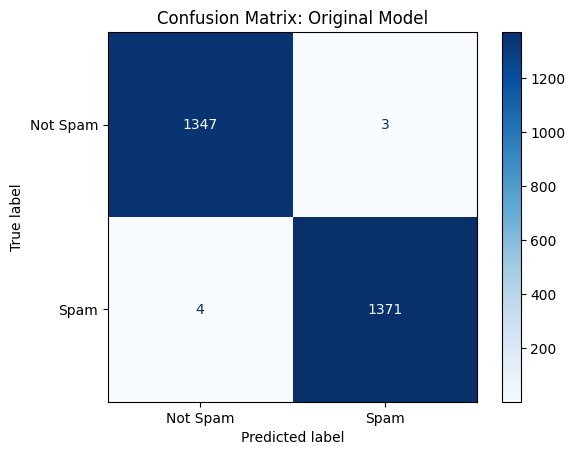

Confusion Matrix for Updated Model


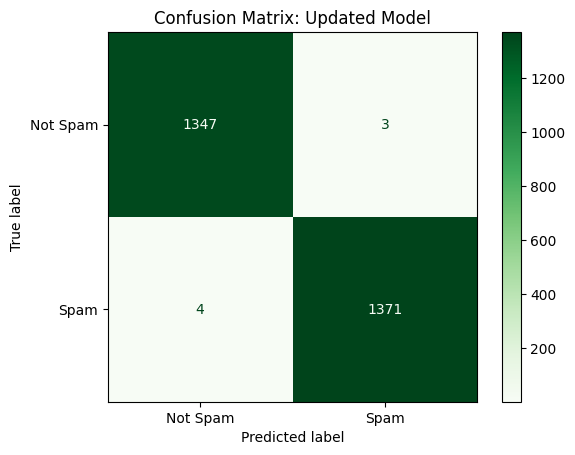

In [49]:
import matplotlib.pyplot as plt

# Display confusion matrix for the original model
print("Confusion Matrix for Original Model")
disp_original = ConfusionMatrixDisplay(confusion_matrix=cm_original, display_labels=['Not Spam', 'Spam'])
disp_original.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix: Original Model")
plt.show()

# Display confusion matrix for the updated model
print("Confusion Matrix for Updated Model")
disp_updated = ConfusionMatrixDisplay(confusion_matrix=cm_updated, display_labels=['Not Spam', 'Spam'])
disp_updated.plot(cmap='Greens', values_format='d')
plt.title("Confusion Matrix: Updated Model")
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_normalized_confusion_matrix(model_predictions, true_labels, title, cmap='Blues'):
    # Generate confusion matrix
    cm = confusion_matrix(true_labels, model_predictions)

    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Display the normalized confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=['Not Spam', 'Spam'])
    disp.plot(cmap=cmap, values_format=".2f")
    plt.title(title)
    plt.show()

# Example usage for the original model
original_predictions = ...  # Replace with your model's predictions on the test set
true_labels = ...           # Replace with the true labels of the test set
plot_normalized_confusion_matrix(original_predictions, true_labels, "Normalized Confusion Matrix: Original Model")

# Example usage for the updated model
updated_predictions = ...   # Replace with your updated model's predictions on the test set
plot_normalized_confusion_matrix(updated_predictions, true_labels, "Normalized Confusion Matrix: Updated Model", cmap='Greens')
